In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model Class
class MNISTDigitClassifier(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=hidden_units, kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # (B, C, H, W) -> (B, C*H*W)
            nn.Linear(in_features=360, out_features=out_features) # The value 360 is found by the computations
            # done in the cells below.
        )

    def forward(self, X):
        conv1_output = self.conv_layer_1(X)
        conv2_output = self.conv_layer_2(conv1_output)
        classifier_output = self.classifier(conv2_output)
        
        return classifier_output

In [3]:
cnn_model = MNISTDigitClassifier(in_features=1, hidden_units=10, out_features=10)

In [4]:
cnn_model.load_state_dict(torch.load('./saved models/MNIST_model.pth', weights_only=True))

<All keys matched successfully>

In [5]:
# Deep inversion attack
# Create a random image
torch.manual_seed(42)
random_image = torch.rand(size=(1, 1, 28, 28), requires_grad=True) # requires_grad = True is very important here for our purpose.
random_image

tensor([[[[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936,
           0.9408, 0.1332, 0.9346, 0.5936, 0.8694, 0.5677, 0.7411, 0.4294,
           0.8854, 0.5739, 0.2666, 0.6274, 0.2696, 0.4414, 0.2969, 0.8317,
           0.1053, 0.2695, 0.3588, 0.1994],
          [0.5472, 0.0062, 0.9516, 0.0753, 0.8860, 0.5832, 0.3376, 0.8090,
           0.5779, 0.9040, 0.5547, 0.3423, 0.6343, 0.3644, 0.7104, 0.9464,
           0.7890, 0.2814, 0.7886, 0.5895, 0.7539, 0.1952, 0.0050, 0.3068,
           0.1165, 0.9103, 0.6440, 0.7071],
          [0.6581, 0.4913, 0.8913, 0.1447, 0.5315, 0.1587, 0.6542, 0.3278,
           0.6532, 0.3958, 0.9147, 0.2036, 0.2018, 0.2018, 0.9497, 0.6666,
           0.9811, 0.0874, 0.0041, 0.1088, 0.1637, 0.7025, 0.6790, 0.9155,
           0.2418, 0.1591, 0.7653, 0.2979],
          [0.8035, 0.3813, 0.7860, 0.1115, 0.2477, 0.6524, 0.6057, 0.3725,
           0.7980, 0.8399, 0.1374, 0.2331, 0.9578, 0.3313, 0.3227, 0.0162,
           0.2137, 0.6249, 0.4340, 0.1371, 

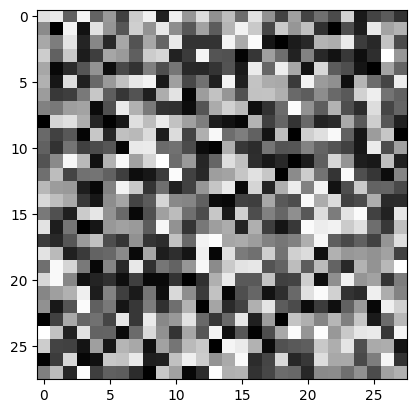

In [6]:
# Visualize this random image
plt.imshow(random_image.detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')

In [7]:
label = 5 # We want to see what needs to be fed to the model to get the label 5 (digit 6)

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([random_image], lr=0.0001, momentum=0.9)

In [9]:
rounds = 200000
for i in range(0, rounds):
    logits = cnn_model(random_image)

    loss = loss_function(logits, torch.tensor(label).unsqueeze(dim=0))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if i % 1000 == 0:
        print(f'Round: {i}. Loss: {loss.item()}')

Round: 0. Loss: 6.957412242889404
Round: 1000. Loss: 0.0008755664457567036
Round: 2000. Loss: 0.0005220004240982234
Round: 3000. Loss: 0.00037377048283815384
Round: 4000. Loss: 0.00029213930247351527
Round: 5000. Loss: 0.00024053541710600257
Round: 6000. Loss: 0.0002047805901383981
Round: 7000. Loss: 0.00017855956684798002
Round: 8000. Loss: 0.00015829740732442588
Round: 9000. Loss: 0.00014232576359063387
Round: 10000. Loss: 0.0001294529065489769
Round: 11000. Loss: 0.00011860620725201443
Round: 12000. Loss: 0.00010954733443213627
Round: 13000. Loss: 0.00010179955279454589
Round: 14000. Loss: 9.512448741588742e-05
Round: 15000. Loss: 8.940297266235575e-05
Round: 16000. Loss: 8.427741704508662e-05
Round: 17000. Loss: 7.986703712958843e-05
Round: 18000. Loss: 7.581423415103927e-05
Round: 19000. Loss: 7.211902266135439e-05
Round: 20000. Loss: 6.878139538457617e-05
Round: 21000. Loss: 6.568216485902667e-05
Round: 22000. Loss: 6.294052582234144e-05
Round: 23000. Loss: 6.0437283536884934e-05

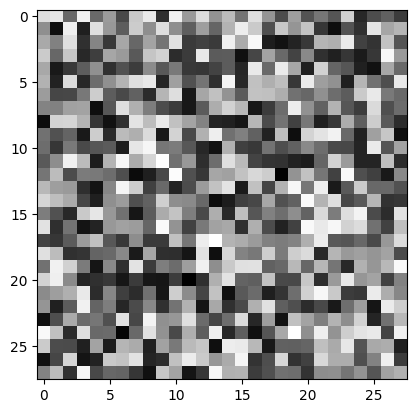

In [10]:
# Visualize this random image after training
plt.imshow(random_image.detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')

In [11]:
random_image.shape

torch.Size([1, 1, 28, 28])

In [12]:
def func(x):
    min_value = 0.1
    if x > min_value:
        return x
    return 0

In [13]:
random_image = random_image.detach().apply_(func)

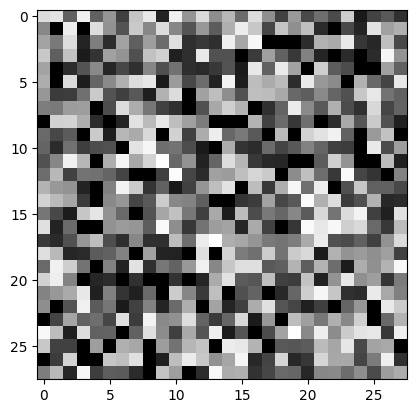

In [14]:
# Visualize this random image after training and cutting off some pixels
plt.imshow(random_image.detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')

In [15]:
# Predict
logits = cnn_model(random_image)
logits

tensor([[  1.7012, -11.9649,   6.6852,   5.3327, -11.6066,  19.8479,  -5.8164,
         -17.1510,   8.4514,   4.5206]], grad_fn=<AddmmBackward0>)